In [1]:
from functions import *

%load_ext autoreload
%aimport functions
%autoreload 1

simulation_dict = read_simulation_csv(case_list = [0, 1, 2, 3, 12, 13, 14, 15], point_multiplier = 8, add = True, s = 30e-9)
plt.rcParams['animation.embed_limit'] = 2**9
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.family'] = 'Times New Roman'

Generating data for nucleations and growth:

In [44]:
# Setup model
size = 50
normal_magnet_type = 1
s = 30e-9
neighbour_dist = 10
info = simulation_dict[normal_magnet_type]
l,w,t = info['l']*1e-9,info['w']*1e-9,info['t']*1e-9
hc,b,c,beta,gamma = info['hc'],info['b'],info['c'],info['beta'],info['gamma']
alpha = get_alpha(l,w,t,s)
model_params = {
    'size': (size,size), 
    'hc': hc, 
    'sw_b': b, 
    'sw_c': c,
    'sw_beta': beta,
    'sw_gamma': gamma,
    'alpha': alpha, 
    'use_opencl': True,
    'neighbor_distance': neighbour_dist,
}
model = PinwheelSpinIceDiamond(**model_params)
model_angle = copy.deepcopy(model.angle)

# Parameters
disorder = 0
alpha = 0.001
model.set_alpha(alpha)
theta_i = 16
theta_nucs = [45,-45] 
defect_names = ['1c', '2c', '3c', '4c', '1e', '2e', '3e', '4e']  #'1c', '2c', '3c', '4c', '1e', '2e', '3e', '4e'
run_range = 1


In [33]:
def nuclate(model, hc, alpha, defect_name, defect_idxs, disorder, theta_nucs, id):
    "Increase field until something nucleate, then return index."
    
    model.polarize(-1)
    spin0 = np.sum(model.spin)
    H_nuc = 0.03
    while abs(np.sum(model.spin) - spin0)<len(defect_idxs)*2 and H_nuc<0.08: #0.08
        H_nuc += 0.0001
        for theta_nuc in theta_nucs:
            h_nuc = np.array([H_nuc*np.cos(np.deg2rad(theta_nuc)), H_nuc*np.sin(np.deg2rad(theta_nuc))])
            model.set_h_ext(h_nuc)
            model.relax()
    flipped = np.argwhere(model.spin>0).flatten().tolist()
    if -np.sum(model.spin)==spin0:
        return model, flipped, pd.DataFrame({'Id':id, 'Defect_name': defect_name, 'Alpha':alpha, 'Disorder':disorder, 'Hc': np.round(hc,4), 'Theta_nuc': theta_nuc, 'H_nuc':  np.round(H_nuc,4), 'Nuc_ratio': [f"{len(flipped)}:{len(defect_idxs)}"], 'Success': 'Fail', 'Partial_success': 'Fail'})
    elif len(flipped)>2*len(defect_idxs):
        return model, flipped, pd.DataFrame({'Id':id, 'Defect_name': defect_name, 'Alpha':alpha, 'Disorder':disorder, 'Hc': np.round(hc,4), 'Theta_nuc': theta_nuc, 'H_nuc':  np.round(H_nuc,4), 'Nuc_ratio': [f"{len(flipped)}:{len(defect_idxs)}"], 'Success': False, 'Partial_success': np.all([i in flipped for i in defect_idxs])})
    return model, flipped, pd.DataFrame({'Id':id, 'Defect_name': defect_name, 'Alpha':alpha, 'Disorder':disorder, 'Hc': np.round(hc,4), 'Theta_nuc': theta_nuc, 'H_nuc':  np.round(H_nuc,4), 'Nuc_ratio': [f"{len(flipped)}:{len(defect_idxs)}"], 'Success': flipped==defect_idxs, 'Partial_success': np.all([i in flipped for i in defect_idxs])})
    
def growth(model, flipped):
    "Grow a nucleated ASI"
    H_ext = 0.040
    theta_exts = [22, 338]
    
    while H_ext<0.080:
        H_ext += 0.0001
        model.polarize(-1)
        spin0 = np.sum(model.spin)
        model.flip(flipped)
        flipped_growth = [flipped]
        
        spin = np.inf
        while spin != np.sum(model.spin):
            spin = np.sum(model.spin) 
            for theta_ext in theta_exts:
                h_ext = np.array([H_ext*np.cos(np.deg2rad(theta_ext)), -H_ext*np.sin(np.deg2rad(theta_ext))])
                model.set_h_ext(h_ext)
                model.relax()
            flipped_growth.append(np.argwhere(model.spin>0).flatten().tolist())
            if abs(spin0 + np.sum(model.spin)) < abs(spin0)*7/4: # Clock until 1/8 is flipped (Flipping 1/8 removes 1/4 of the total spin)
                return flipped_growth, H_ext, abs((spin0 - np.sum(model.spin))/(2*spin0)), np.sum(model.spin)
    return print("Error: max H_ext reached!")

def plot_gray(i, model, flipped_grow, ax, defect_name, range_list):
    model.polarize(-1)
    model.flip(flipped_grow[i])
    C = (model.vectors[...,0]>0)*256
    ax.clear()
    ax.quiver(model.pos[:,0],model.pos[:,1], model.vectors[...,0], model.vectors[...,1], color=cm.gray(C), pivot='mid')
    ax.set_title(f"{defect_name} Run{np.searchsorted(range_list,i,side='right')}", fontsize=20)


In [8]:
# Nucleate, grow, plot and store data

if not os.path.exists(f'Data\\Angle_Alpha{alpha}_Dis{disorder}'):
    os.makedirs(f'Data\\Angle_Alpha{alpha}_Dis{disorder}')

for defect_name in tqdm(defect_names, desc ="Run", position=0, leave=True):
    defect_idxs = defect_idxs_dict_n50[defect_name]
    mod_ang = copy.deepcopy(model_angle)
    mod_ang[defect_idxs] = np.sign(mod_ang[defect_idxs])*np.deg2rad(theta_i)
    model.set_angle(mod_ang)
    
    data_list = []
    threshold_dist_list = []
    flipped_list = []
    flipped_grow_list = []
    
    for id in range(run_range): 
        # Nucleate
        threshold_dist = np.random.normal(1, disorder, size=model.spin_count)
        threshold = hc*threshold_dist
        model.set_threshold(threshold)

        model, flipped, new_data = nuclate(model=model, hc=hc, alpha=alpha, defect_name=defect_name, defect_idxs=defect_idxs, disorder=disorder, theta_nucs=theta_nucs, id=id)
        threshold_dist_list.append(threshold_dist)
        flipped_list.append(flipped)
        
        # Growth
        flipped_grow, H_ext, spin_end, spin = growth(model, flipped)
        flipped_grow_list.append(flipped_grow)
        new_data['H_ext'] = f"{H_ext:.5f}"
        new_data['Spin_end'] = f"{spin_end:.1%}"
        new_data['Spin'] = spin
        data_list.append(new_data)

    result = pd.concat(data_list, ignore_index=True)  
    nuc_path = f'Data\\Angle_Alpha{alpha}_Dis{disorder}\\Nuc_Alpha{alpha}_Dis{disorder}.csv' 
    if os.path.isfile(nuc_path):
        result.to_csv(path_or_buf=nuc_path, mode='a', index=False, header=False)
    else:
        result.to_csv(path_or_buf=nuc_path, mode='a', index=False, header=True)
    
    File_num = 0
    pickle_path = f'Data\\Angle_Alpha{alpha}_Dis{disorder}\\Alpha{alpha}_Dis{disorder}_{defect_name}' 
    new_pickle_path = pickle_path
    while os.path.isfile(new_pickle_path + '.pickle'):
        new_pickle_path = pickle_path +'_'+ str(File_num)
        File_num += 1
    
    with open(new_pickle_path+'.pickle', 'wb') as file:
        pickle.dump({'Defect_name': defect_name, 'Alpha':alpha, 'Disorder':disorder, 'Theta_nuc': theta_nucs[0]}, file)
        if disorder==0:
            pickle.dump([],file)
        else:
            pickle.dump(threshold_dist_list, file)
        pickle.dump(flipped_list, file)
        pickle.dump(flipped_grow_list, file)
    
    # Plot growth
    flipped_grow = [i for j in flipped_grow_list for i in j]
    range_list = [0]
    for i in range(len(flipped_grow_list)): range_list.append(range_list[-1]+len(flipped_grow_list[i]))
    range_list = range_list[1:]

    fig, ax = plt.subplots(figsize=[4.8,4.8])
    ax.set_facecolor("Gray")
    anim = FuncAnimation(fig, plot_gray, frames=len(flipped_grow), fargs=(model, flipped_grow, ax, defect_name, range_list), interval=500)
    plt.close()
    htlm = HTML(anim.to_jshtml())

    with open(f'Data\\Angle_Alpha{alpha}_Dis{disorder}\\Plots alpha{alpha}_Dis{disorder}_Name{defect_name}.html', 'w') as f:
        f.write(htlm.data)

# Joining htmls
html_list = []
for defect_name in tqdm(defect_names, desc ="Run", position=0, leave=True):
    with open(f'Data\\Angle_Alpha{alpha}_Dis{disorder}\\Plots alpha{alpha}_Dis{disorder}_Name{defect_name}.html', 'r') as f:
        html_list.append(f.read())
with open(f'Data\\Angle_Alpha{alpha}_Dis{disorder}\\Plots alpha{alpha}_Dis{disorder}.html', 'w') as f:
    f.write(f"</title>\n</head> <body><h1>Alpha:{alpha}, disorder {disorder}</h1>") 
    for a in html_list:
        f.write(a)



Run:   0%|          | 0/8 [00:00<?, ?it/s]C:\Users\eivhe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
Run: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


In [46]:
# Test clocking steps and [-45,45] vs [45,-45]
defect_name = '3c'
defect_idxs = defect_idxs_dict_n50[defect_name]
mod_ang = copy.deepcopy(model_angle)
mod_ang[defect_idxs] = np.sign(mod_ang[defect_idxs])*np.deg2rad(theta_i)
model.set_angle(mod_ang)


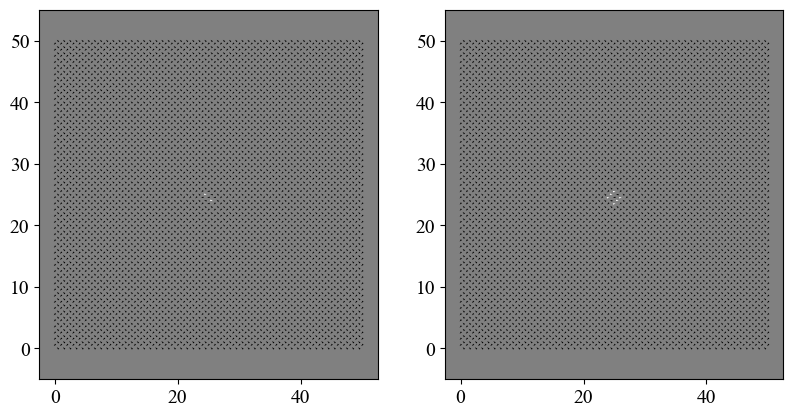

In [47]:
model.polarize(-1)
H_nuc = 0.0508
i = 0
fig, ax = plt.subplots(1,2,figsize=[9.6,4.8])
for theta_nuc in theta_nucs:
    h_nuc = np.array([H_nuc*np.cos(np.deg2rad(theta_nuc)), H_nuc*np.sin(np.deg2rad(theta_nuc))])
    model.set_h_ext(h_nuc)
    # model.step()
    # model.step()
    # model.step()
    model.relax()
    C = (model.vectors[...,0]>0)*256
    ax[i].quiver(model.pos[:,0],model.pos[:,1], model.vectors[...,0], model.vectors[...,1], color=cm.gray(C), pivot='mid')
    ax[i].axis('equal')
    ax[i].set_facecolor("Gray")
    i +=1
    
plt.show()